In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Set the correct paths based on your Drive structure
image_dir = '/content/drive/MyDrive/health_app/brain/brain_segmentation/images'
mask_dir = '/content/drive/MyDrive/health_app/brain/brain_segmentation/masks'

# Get sorted list of file paths (to keep image-mask pairs aligned)
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Check number of images and masks
print(f"Total images: {len(image_paths)}")
print(f"Total masks: {len(mask_paths)}")

Total images: 3064
Total masks: 3064


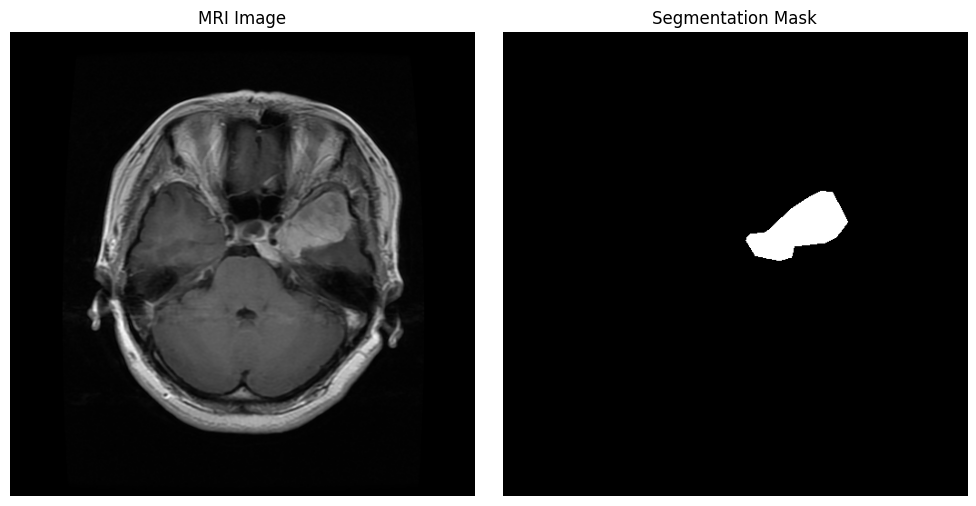

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load one image and its corresponding mask
img = cv2.imread(image_paths[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

# Display side-by-side
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('MRI Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence

class BrainMRIDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, img_size=(256, 256), shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_imgs = []
        batch_masks = []

        for i in batch_indices:
            img = cv2.imread(self.image_paths[i])
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize

            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.img_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

# Set image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 8

# Create generators
train_gen = BrainMRIDataGenerator(train_imgs, train_masks, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen = BrainMRIDataGenerator(val_imgs, val_masks, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bridge
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Build the model
model = build_unet_model(input_size=(256, 256, 3))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks (optional but helpful)
checkpoint = tf.keras.callbacks.ModelCheckpoint("unet_best_model.h5", save_best_only=True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9815 - loss: 0.1379
Epoch 1: val_loss improved from inf to 0.07055, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 1307s 4s/step - accuracy: 0.9815 - loss: 0.1377 - val_accuracy: 0.9822 - val_loss: 0.0706
Epoch 2/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9828 - loss: 0.0694
Epoch 2: val_loss did not improve from 0.07055
306/306 ━━━━━━━━━━━━━━━━━━━━ 144s 468ms/step - accuracy: 0.9828 - loss: 0.0694 - val_accuracy: 0.9822 - val_loss: 0.0711
Epoch 3/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9821 - loss: 0.0738
Epoch 3: val_loss did not improve from 0.07055
306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 443ms/step - accuracy: 0.9821 - loss: 0.0738 - val_accuracy: 0.9822 - val_loss: 0.0756
Epoch 4/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9823 - loss: 0.0734
Epoch 4: val_loss did not improve from 0.07055
306/306 ━━━━━━━━━━━━━━━━━━━━ 134s 437ms/step - accuracy: 0.9823 - loss: 0.0734 - val_accuracy: 0.9822 - val_loss: 0.0719
Epoch 5/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9824 - loss: 0.0722
Epoch 5: val_loss improve

306/306 ━━━━━━━━━━━━━━━━━━━━ 138s 451ms/step - accuracy: 0.9824 - loss: 0.0722 - val_accuracy: 0.9822 - val_loss: 0.0698
Epoch 6/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9823 - loss: 0.0696
Epoch 6: val_loss improved from 0.06979 to 0.06649, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 442ms/step - accuracy: 0.9823 - loss: 0.0696 - val_accuracy: 0.9822 - val_loss: 0.0665
Epoch 7/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9821 - loss: 0.0695
Epoch 7: val_loss did not improve from 0.06649
306/306 ━━━━━━━━━━━━━━━━━━━━ 137s 444ms/step - accuracy: 0.9821 - loss: 0.0695 - val_accuracy: 0.9822 - val_loss: 0.0671
Epoch 8/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9826 - loss: 0.0662
Epoch 8: val_loss did not improve from 0.06649
306/306 ━━━━━━━━━━━━━━━━━━━━ 134s 439ms/step - accuracy: 0.9826 - loss: 0.0662 - val_accuracy: 0.9822 - val_loss: 0.0674
Epoch 9/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9828 - loss: 0.0634
Epoch 9: val_loss improved from 0.06649 to 0.06413, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 140s 458ms/step - accuracy: 0.9828 - loss: 0.0634 - val_accuracy: 0.9822 - val_loss: 0.0641
Epoch 10/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9830 - loss: 0.0609
Epoch 10: val_loss improved from 0.06413 to 0.06311, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 137s 446ms/step - accuracy: 0.9830 - loss: 0.0609 - val_accuracy: 0.9823 - val_loss: 0.0631
Epoch 11/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9826 - loss: 0.0605
Epoch 11: val_loss improved from 0.06311 to 0.05864, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 142s 445ms/step - accuracy: 0.9826 - loss: 0.0605 - val_accuracy: 0.9825 - val_loss: 0.0586
Epoch 12/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9831 - loss: 0.0575
Epoch 12: val_loss improved from 0.05864 to 0.05437, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 445ms/step - accuracy: 0.9831 - loss: 0.0575 - val_accuracy: 0.9837 - val_loss: 0.0544
Epoch 13/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9837 - loss: 0.0546
Epoch 13: val_loss improved from 0.05437 to 0.05349, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 153s 481ms/step - accuracy: 0.9837 - loss: 0.0546 - val_accuracy: 0.9839 - val_loss: 0.0535
Epoch 14/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9831 - loss: 0.0558
Epoch 14: val_loss improved from 0.05349 to 0.05173, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 445ms/step - accuracy: 0.9831 - loss: 0.0558 - val_accuracy: 0.9840 - val_loss: 0.0517
Epoch 15/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9844 - loss: 0.0507
Epoch 15: val_loss improved from 0.05173 to 0.04928, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 140s 457ms/step - accuracy: 0.9844 - loss: 0.0507 - val_accuracy: 0.9845 - val_loss: 0.0493
Epoch 16/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9836 - loss: 0.0516
Epoch 16: val_loss did not improve from 0.04928
306/306 ━━━━━━━━━━━━━━━━━━━━ 135s 439ms/step - accuracy: 0.9836 - loss: 0.0516 - val_accuracy: 0.9846 - val_loss: 0.0494
Epoch 17/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9846 - loss: 0.0492
Epoch 17: val_loss improved from 0.04928 to 0.04889, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 446ms/step - accuracy: 0.9846 - loss: 0.0492 - val_accuracy: 0.9847 - val_loss: 0.0489
Epoch 18/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9844 - loss: 0.0492
Epoch 18: val_loss improved from 0.04889 to 0.04768, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 149s 486ms/step - accuracy: 0.9844 - loss: 0.0492 - val_accuracy: 0.9849 - val_loss: 0.0477
Epoch 19/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9850 - loss: 0.0472
Epoch 19: val_loss improved from 0.04768 to 0.04608, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 444ms/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9852 - val_loss: 0.0461
Epoch 20/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9848 - loss: 0.0467
Epoch 20: val_loss did not improve from 0.04608
306/306 ━━━━━━━━━━━━━━━━━━━━ 144s 471ms/step - accuracy: 0.9848 - loss: 0.0467 - val_accuracy: 0.9850 - val_loss: 0.0470
Epoch 21/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9850 - loss: 0.0459
Epoch 21: val_loss improved from 0.04608 to 0.04532, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 444ms/step - accuracy: 0.9850 - loss: 0.0459 - val_accuracy: 0.9854 - val_loss: 0.0453
Epoch 22/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9854 - loss: 0.0443
Epoch 22: val_loss did not improve from 0.04532
306/306 ━━━━━━━━━━━━━━━━━━━━ 135s 440ms/step - accuracy: 0.9854 - loss: 0.0443 - val_accuracy: 0.9852 - val_loss: 0.0461
Epoch 23/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9848 - loss: 0.0461
Epoch 23: val_loss improved from 0.04532 to 0.04415, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 137s 446ms/step - accuracy: 0.9848 - loss: 0.0461 - val_accuracy: 0.9857 - val_loss: 0.0441
Epoch 24/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9855 - loss: 0.0435
Epoch 24: val_loss did not improve from 0.04415
306/306 ━━━━━━━━━━━━━━━━━━━━ 135s 439ms/step - accuracy: 0.9855 - loss: 0.0435 - val_accuracy: 0.9841 - val_loss: 0.0478
Epoch 25/25
306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9860 - loss: 0.0425
Epoch 25: val_loss improved from 0.04415 to 0.04363, saving model to unet_best_model.h5


306/306 ━━━━━━━━━━━━━━━━━━━━ 136s 444ms/step - accuracy: 0.9860 - loss: 0.0425 - val_accuracy: 0.9858 - val_loss: 0.0436


In [ ]:
# Define a path to save the model in your Drive
model_save_path = '/content/drive/MyDrive/health_app/brain/unet_model.h5'

# Save the model after training
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/health_app/brain/unet_model.h5


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Post-processing function
# -------------------------
def clean_mask(pred_mask, min_area=200):
    # Binarize prediction
    mask = (pred_mask > 0.5).astype(np.uint8)

    # Morphological closing to fill small holes
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Connected component analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed, connectivity=8)

    # Create a new mask keeping only components above size threshold
    cleaned = np.zeros_like(mask)

    for i in range(1, num_labels):  # skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            cleaned[labels == i] = 1

    return cleaned

In [44]:
from google.colab import files
uploaded = files.upload()

Saving mri_scan.jpeg to mri_scan.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


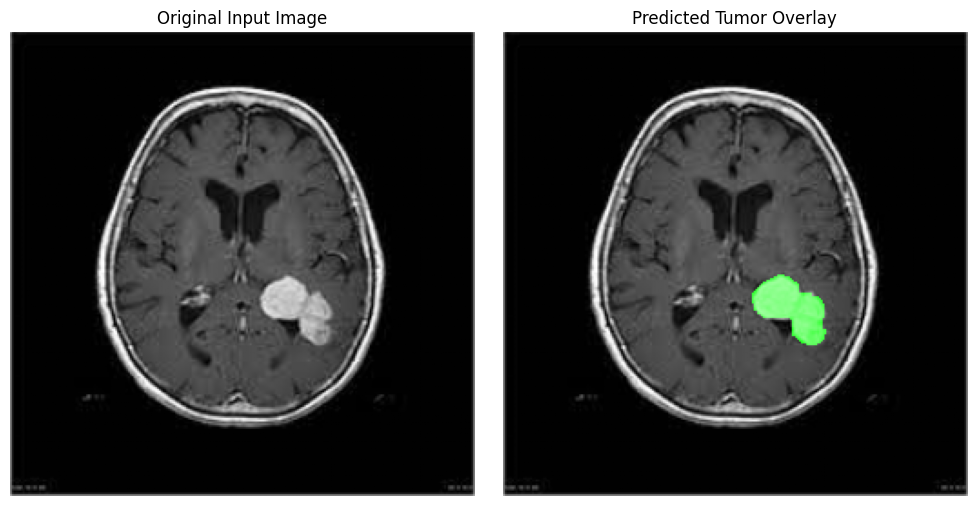

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Replace this with your uploaded filename
uploaded_filename = list(uploaded.keys())[0]

# Load and preprocess
img = cv2.imread(uploaded_filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (256, 256)) / 255.0
input_img = np.expand_dims(img_resized, axis=0)

# Predict
pred = model.predict(input_img)[0].squeeze()

# Post-process
cleaned_mask = clean_mask(pred)

# Overlay setup (green mask)
overlay = img_resized.copy()
green_mask = np.zeros_like(overlay)
green_mask[..., 1] = 255

overlay[cleaned_mask == 1] = cv2.addWeighted(
    overlay, 0.7, green_mask, 0.3, 0
)[cleaned_mask == 1]

# Show result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Original Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Predicted Tumor Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()